In [1]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.misc import imread
import glob
import copy

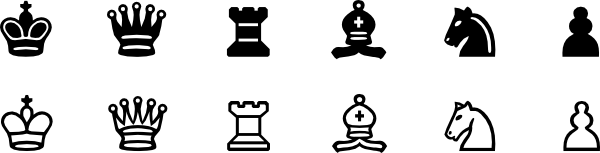

In [140]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get(
    'http://www.clker.com/cliparts/c/b/8/6/11949911991537719366chess_set_symbols_igor_k_01.svg.hi.png')

# img = np.array(Image.open('chess_pieces.png'))[:,:,3]
img = Image.open(BytesIO(response.content)).convert("RGBA")

datas = img.getdata()

newData = []
for item in datas:
    if item[0] == 255 and item[1] == 255 and item[2] == 255:
        newData.append((255, 255, 255, 0))
    else:
        newData.append(item)

img.putdata(newData)
    
img

In [148]:
chess_vector = np.array(img)

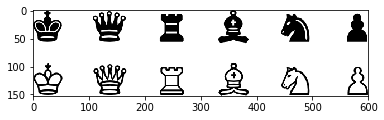

In [266]:
plt.imshow(chess_vector)
plt.show()

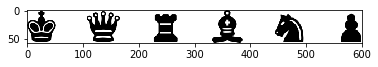

In [267]:
black = chess_vector[:58,:]
plt.imshow(black)

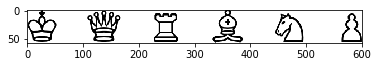

In [151]:
white = chess_vector[-58:,:]
plt.imshow(white)

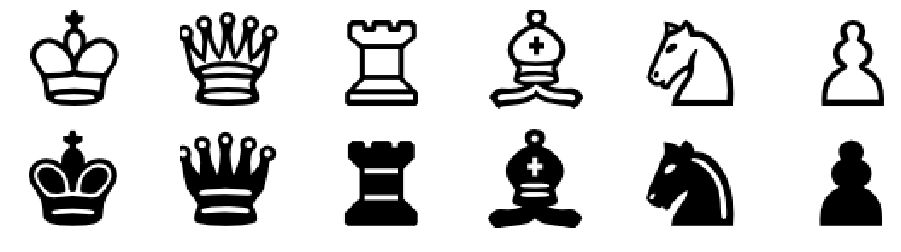

In [348]:
white_pieces = ['king_w','queen_w','rook_w','bishop_w','knight_w','pawn_w'] #key for white chess pieces dictionary
black_pieces = ['king_b','queen_b','rook_b','bishop_b','knight_b','pawn_b'] #key for black chess pieces dictionary

w = [white[:,n*100:(n+1)*100] for n in range(6)] #rough cropping for white chess pieces
b = [black[:,n*100:(n+1)*100] for n in range(6)] #rough cropping for black chess pieces

w_new = [] #editted cropping
b_new = [] #editted cropping

for i,j in zip(range(0,60,10), range(len(w)+1)): #fix pawn
    w_new.append(w[j][:,i:i+side_len])
    b_new.append(b[j][:,i:i+side_len])
    
w_new[0] = Image.fromarray(np.roll(w_new[0], 4))
w_new[1] = Image.fromarray(np.roll(w_new[1], 0))
w_new[2] = Image.fromarray(np.roll(w_new[2], 0))
w_new[-3] = Image.fromarray(np.roll(w_new[-3], 0))
w_new[-2] = Image.fromarray(np.roll(w_new[-2], 0))
w_new[-1] = Image.fromarray(np.roll(w_new[-1], 0))

b_new[0] = Image.fromarray(np.roll(b_new[0], 4))
b_new[1] = Image.fromarray(np.roll(b_new[1], 0))
b_new[2] = Image.fromarray(np.roll(b_new[2], 0))
b_new[-3] = Image.fromarray(np.roll(b_new[-3], 0))
b_new[-2] = Image.fromarray(np.roll(b_new[-2], 0))
b_new[-1] = Image.fromarray(np.roll(b_new[-1], 0))

blank_space = np.full((58, 58, 4), 255.) #fixed pawn
blank_space[0:58, 4:54] = w_new[5]
blank_space[0:58,:4] = 0
blank_space[0:58,54:] = 0
w_new[5] = Image.fromarray(np.uint8(blank_space))

blank_space = np.full((58, 58, 4), 255.) #fixed pawn
blank_space[0:58, 4:54] = b_new[5]
blank_space[0:58,:4] = 0
blank_space[0:58,54:] = 0
b_new[5] = Image.fromarray(np.uint8(blank_space))


fig, ax = plt.subplots(2,6,figsize=(16,4))
for idx, im in enumerate(w_new):
    ax[0,idx].imshow(im)
    ax[0,idx].axis('off')
    
for idx, im in enumerate(b_new):
    ax[1,idx].imshow(im)
    ax[1,idx].axis('off')

AxesImage(54,36;334.8x217.44)


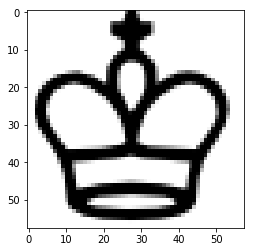

In [349]:
white_dict = dict(zip(white_pieces, w_new))
black_dict = dict(zip(black_pieces, b_new))
print plt.imshow(white_dict['king_w'])

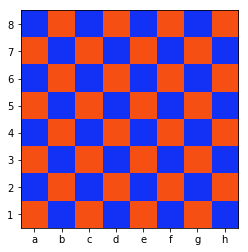

In [350]:
def init_board():
    block_w = np.full((60*60,),0, dtype=np.int).reshape(60,60)
    block_b = np.full((60*60,),255, dtype=np.int).reshape(60,60)
    
    row1 = np.hstack([block_w,block_b])
    row1 = np.hstack([row1,row1])
    row1 = np.hstack([row1,row1])
    row2 = np.roll(row1,60)

    board = np.vstack([row1,row2])
    board = np.vstack([board,board])
    board = np.vstack([board,board])

    board = np.array(Image.fromarray(np.uint8(board)).convert('RGBA'))
    r1,g1,b1 = 0,0,0
    r2,g2,b2 = 19,49,245
    r3,g3,b3 = 255,255,255
    r4,g4,b4 = 245,79,19
    
    red,green,blue = board[:,:,0], board[:,:,1], board[:,:,2]
    mask1 = (red == r1) & (green == g1) & (blue == b1)
    board[:,:,:3][mask1] = [r2,g2,b2]

    red,green,blue = board[:,:,0], board[:,:,1], board[:,:,2]
    mask1 = (red == r3) & (green == g3) & (blue == b3)
    board[:,:,:3][mask1] = [r4,g4,b4]
    
    board = Image.fromarray(board)
    
    return board

board = init_board()

plt.imshow(board)
plt.xticks([(val*60)+30 for val in range(8)],list('abcdefgh'))
plt.yticks([(val*60)+30 for val in range(8)][::-1],list('12345678'))
plt.show()

In [368]:
from PIL import ImageMath, ImageOps

def distance2(a, b):
    return (a[0] - b[0]) * (a[0] - b[0]) + (a[1] - b[1]) * (a[1] - b[1]) + (a[2] - b[2]) * (a[2] - b[2])

def makeColorTransparent(image, color, thresh2=0):
    # https://stackoverflow.com/questions/765736/using-pil-to-make-all-white-pixels-transparent/765829
    image = image.convert("RGBA")
    red, green, blue, alpha = image.split()
    image.putalpha(ImageMath.eval("""convert(((((t - d(c, (r, g, b))) >> 31) + 1) ^ 1) * a, 'L')""",
        t=thresh2, d=distance2, c=color, r=red, g=green, b=blue, a=alpha))
    return image

def place_piece(piece, row, col, board, color):
    row_slice = slice(row*60+1,row*60+1+58)
    col_slice = slice(col*60+1, col*60+1+58)

    row_loc, col_loc = row*60+1, col*60+1
    
    piece = makeColorTransparent(piece, (255,255,255))
    if color.lower() == 'w':
        r1,g1,b1 = 0,0,0
        r2,g2,b2 = 255,255,255
        
        piece = np.array(piece)
        
        red,green,blue = piece[:,:,0], piece[:,:,1], piece[:,:,2]
        mask = (red == r1) & (green == g1) & (blue == b1)
        piece[:,:,:3][mask] = [r2,g2,b2]

        piece = Image.fromarray(piece)


    
    blank_pallet = Image.new("RGBA", board.size)
    blank_pallet.paste(piece, (row_loc, col_loc))
    
    new_board = Image.alpha_composite(board, blank_pallet)
    return new_board
    


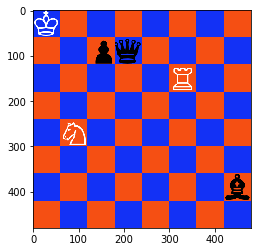

In [369]:
board = init_board()

board = place_piece(white_dict['king_w'], 0, 0, board,'w')
board = place_piece(black_dict['pawn_b'], 2, 1, board,'b')
board = place_piece(black_dict['queen_b'], 3, 1, board,'b')
board = place_piece(white_dict['knight_w'], 1, 4, board,'w')
board = place_piece(white_dict['rook_w'], 5, 2, board,'w')
board = place_piece(black_dict['bishop_b'], 7, 6, board,'b')




plt.imshow(board)

In [ ]:
# make white pieces solid white by exchanging white/black from black pieces
# make a class out of the chess board
    # method - new board
    # method - add piece
    # attr - filled locs
    # attr - dict of piece types with list of (row,col)
    